# Preprocessing

## Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

plt.rcParams.update({'font.size':20})
sns.set(style="whitegrid", font_scale=1.5)

DATA_PATH = "./raw_data"
CONTROL_PATH = os.path.join(DATA_PATH, "control")
CONDITION_PATH = os.path.join(DATA_PATH, "condition")
SCORES_FILE = "scores.csv"

## Read Data

In [29]:
scores_df[scores_df.madrs1 == np.max(scores_df.madrs1)]

,number,days,gender,age,afftype,edu,marriage,work,madrs1,madrs2,MADRS_level,age_level,MADRS_diff
21,condition_22,14,female,65-69,unipolar,NaN,single,unemployed/etc,29.0,28.0,3,Elderly,-1.0
22,condition_23,16,female,30-34,unipolar,16-20,single,unemployed/etc,29.0,23.0,3,Young,-6.0


In [3]:
scores_df = pd.read_csv(os.path.join(DATA_PATH, SCORES_FILE))
scores_df.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [4]:
def get_csv_files(path: str, full=True):
    return [os.path.join(path, f) if full else f for f in os.listdir(path) if f.endswith('.csv')]

ctrl_files = get_csv_files(CONTROL_PATH)
cond_files = get_csv_files(CONDITION_PATH)

## Manipulate columns

MADRS Levels:
- 0: Normal
- 2-6: Mild depression
- 7-19: Moderate depression
- 20-34: Severe depression
- 35-60: Very severe depression

In [5]:
def map_madrs(x):
    if x == 0:
        return 0
    if x <= 6:
        return 1
    if x <= 19:
        return 2
    if x <= 34:
        return 3
    return 4

def map_age(x):
    if x in ['20-24', '25-29', '30-34']:
        return 'Young'
    if x in ['35-39', '40-44', '45-49']:
        return 'Middle-aged'
    return 'Elderly'

scores_df['MADRS_level'] = scores_df.madrs1.apply(map_madrs)

scores_df['age_level'] = scores_df.age.apply(map_age)
scores_df['age_level'] = pd.Categorical(scores_df['age_level'], ["Young", "Middle-aged", "Elderly"])

In [6]:
scores_df['MADRS_diff'] = scores_df.madrs2 - scores_df.madrs1

scores_df = scores_df.drop(columns=['melanch', 'inpatient'])
scores_df['edu'] = scores_df['edu'].replace(' ', np.NaN)

cat_cols = ['age', 'gender', 'edu', 'afftype', 'marriage', 'work']
for col in cat_cols:
    scores_df[col] = scores_df[col].astype('category')

scores_df.gender = scores_df['gender'].cat.rename_categories({1.0 : 'female', 2.0:'male'})
scores_df.afftype = scores_df['afftype'].cat.rename_categories({1.0 : 'bipolar II', 2.0:'unipolar', 3: 'bipolar I'})
scores_df.marriage = scores_df['marriage'].cat.rename_categories({1.0 : 'cohabit', 2.0:'single'})
scores_df.work = scores_df['work'].cat.rename_categories({1.0 : 'work/study', 2.0:'unemployed/etc'})

In [7]:
scores_cond = scores_df[scores_df.number.str.startswith('condition')].dropna()
scores_ctrl = scores_df[scores_df.number.str.startswith('control')].copy()

## Visualization

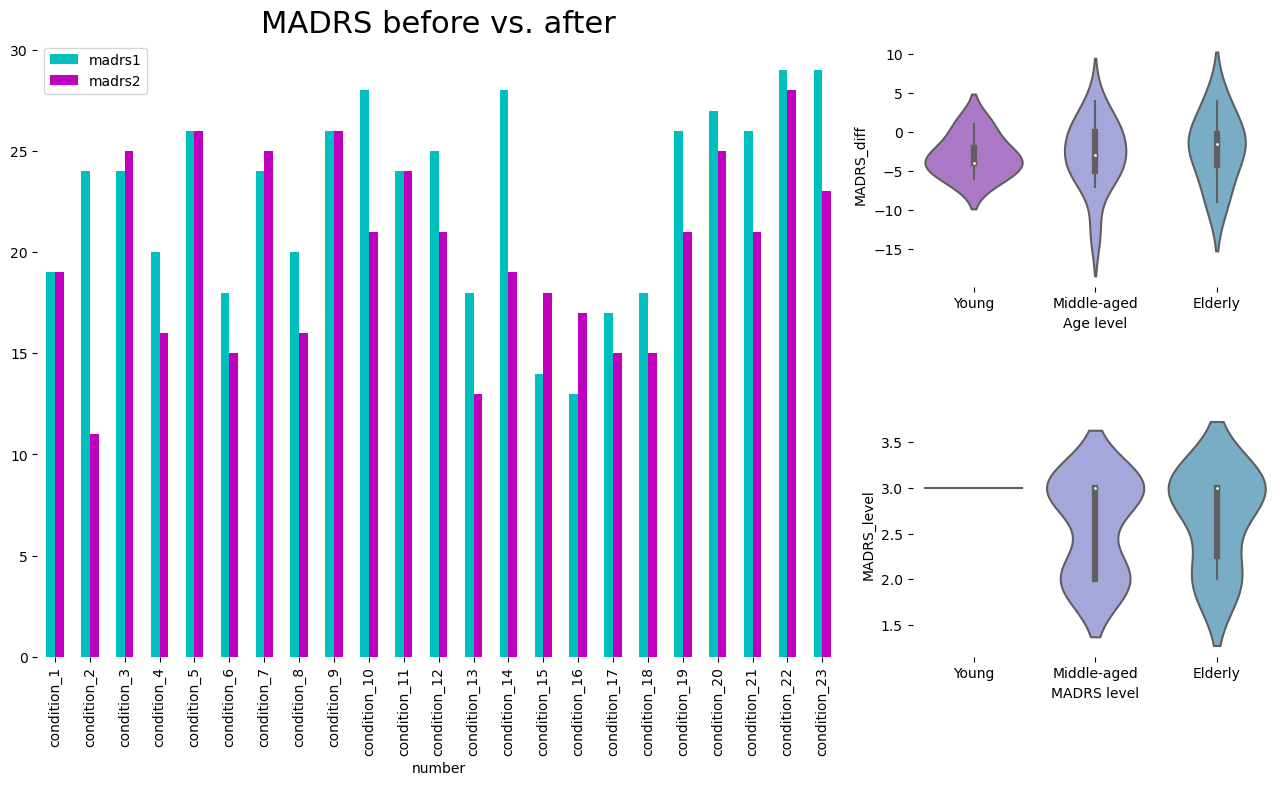

In [57]:
plt.figure(figsize=(16,8))

grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.5)

ax = plt.subplot(grid[0:2,0:2])
scores_cond.plot(x='number', y=['madrs1','madrs2'], kind='bar', ax=ax, color=['c','m'])
ax.set_title("MADRS before vs. after", fontsize=22)

ax = plt.subplot(grid[0,2])
sns.violinplot(data=scores_cond, x="age_level", y="MADRS_diff", saturation=.4, palette="cool_r", ax=ax)
ax.set_xlabel("Age level")

ax = plt.subplot(grid[1,2])
sns.violinplot(data=scores_cond, x="age_level", y="MADRS_level", saturation=.4, palette="cool_r", ax=ax)
ax.set_xlabel("MADRS level")

sns.despine(top=True, right=True, left=True, bottom=True)
plt.savefig('fig1_madrs_v_age.pdf')
plt.show()

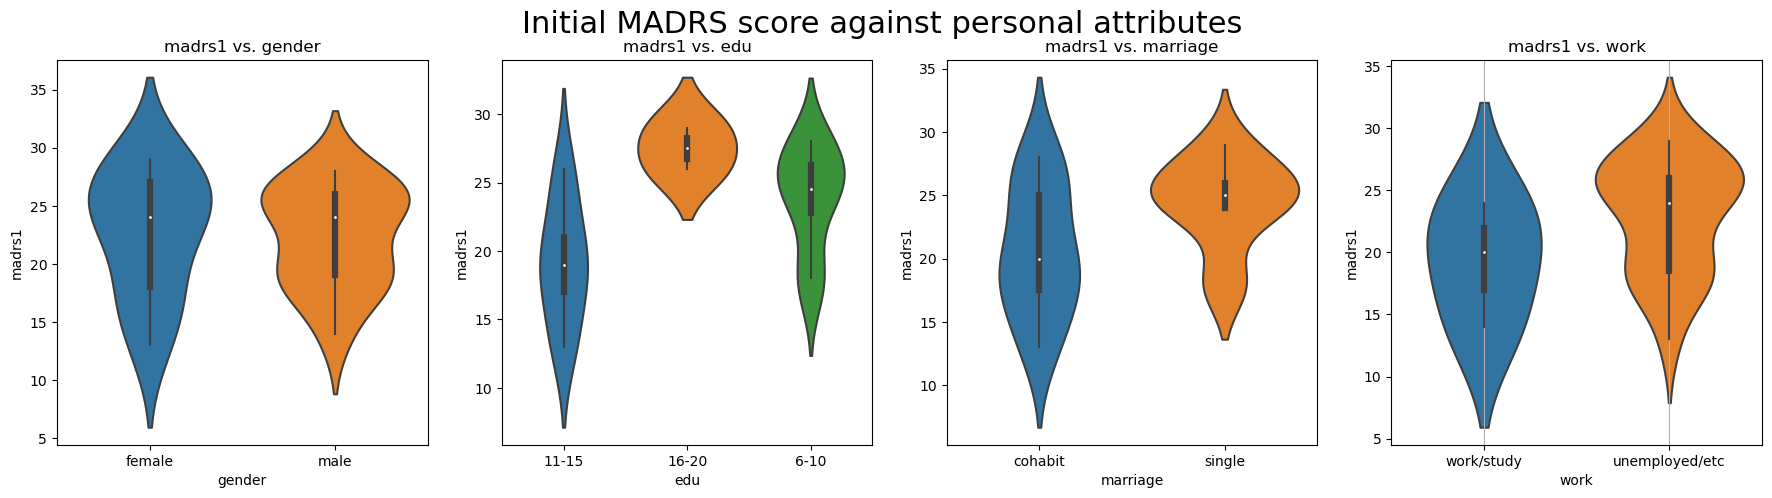

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
fig.suptitle('Initial MADRS score against personal attributes', fontsize=22)
for i, col in enumerate(['gender', 'edu', 'marriage', 'work']):
    sns.violinplot(data=scores_cond.dropna(), x=col, y='madrs1', ax=axes[i])
    axes[i].set_title(f'madrs1 vs. {col}')
    plt.grid()
plt.savefig('fig2_violins.pdf')
plt.show()

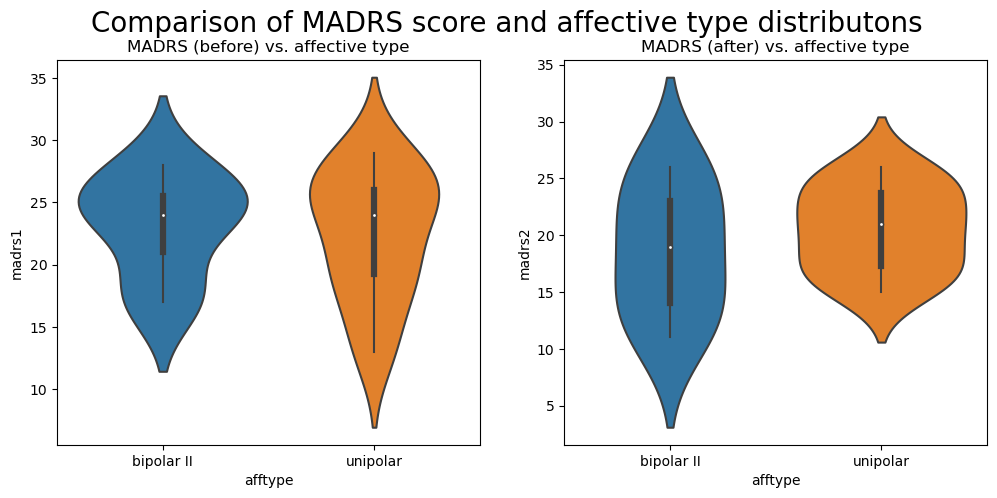

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Comparison of MADRS score and affective type distributons', fontsize=20)

df = scores_cond[scores_cond['afftype'] != 'bipolar I'].dropna()

df.afftype = scores_df['afftype'].cat.rename_categories({1.0 : 'bipolar II', 2.0:'unipolar', 3: 'bipolar I'})
df.afftype = pd.Categorical(df.afftype, ["bipolar II", "unipolar"])

sns.violinplot(data=df, x='afftype', y='madrs1', ax=axes[0])
axes[0].set_title(f'MADRS (before) vs. affective type')
sns.violinplot(data=df, x='afftype', y='madrs2', ax=axes[1])
axes[1].set_title(f'MADRS (after) vs. affective type')

plt.savefig('fig4_aff.pdf')
plt.show()

## Afftype classification

In [22]:
cols = ['gender', 'age', 'edu', 'marriage', 'work', 'madrs1', 'MADRS_level', 'age_level', 'MADRS_diff']

data = scores_cond[cols].copy()
for col in cols:
    if data[col].dtype == 'category':
        label_encoder = LabelEncoder()
        data[col.capitalize()] = label_encoder.fit_transform(data[col])
        data = data.drop(columns=[col])
        
X = data
y = scores_cond['afftype']

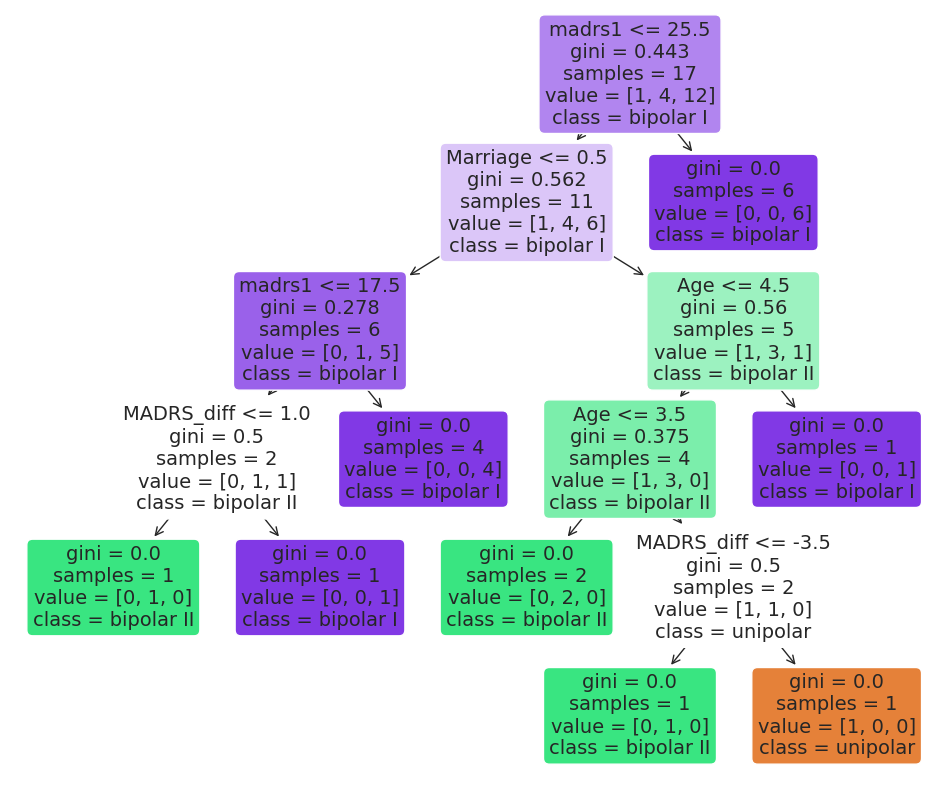

Accuracy on the test set: 0.6
Most important features:
madrs1: 0.26751893939393945
MADRS_diff: 0.265625


In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Visualize the Decision Tree
plt.figure(figsize=(12, 10))
plot_tree(clf, feature_names=data.columns, class_names=scores_cond['afftype'].unique(), filled=True, rounded=True)
plt.savefig('fig_treeplot.pdf')
plt.show()

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")

# Interpret the most important features
feature_importance = clf.feature_importances_
most_important_features = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:2]

print("Most important features:")
for idx in most_important_features:
    print(f"{data.columns[idx]}: {feature_importance[idx]}")
